In [1]:
%matplotlib widget

from PIL import Image
import cv2 
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, HBox

import os
import sys
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
# os.path.abspath(os.path.join('..')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from cv2 import aruco


In [2]:
import glob, os

aruco_samples = []
os.chdir("../res/pose_samples/charuco/tests/sweep")
for file in sorted(glob.glob("*"), key=os.path.getmtime):
    aruco_samples.append(file)

In [3]:
def disp_file(path):
    # In OpenCV, images are in BGR
    # In Pillow, images are in RGB 
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    img = cv2.resize(img, (480, 360))
    display(Image.fromarray(img))

# Display cv2 image
def disp_img(cv_img):
#     cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    cv_img = cv2.resize(cv_img, (480, 360))
    display(Image.fromarray(cv_img))

0 charuco_laser_42.png


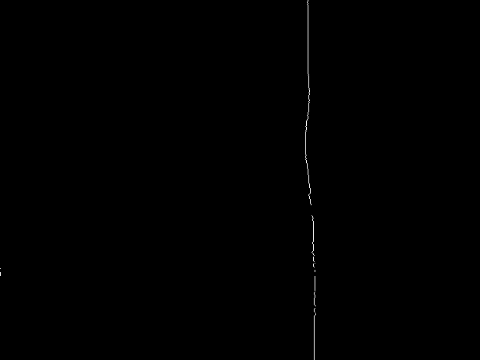

1 charuco_laser_43.png


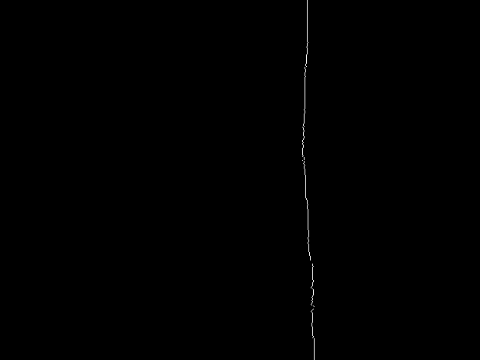

2 charuco_laser_31.png


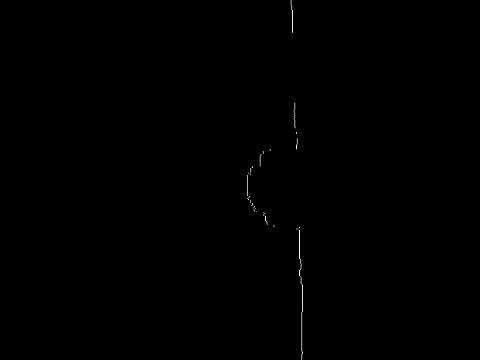

3 charuco_laser_33.png


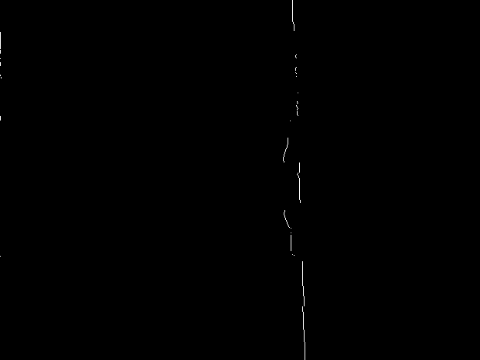

4 charuco_laser_32.png


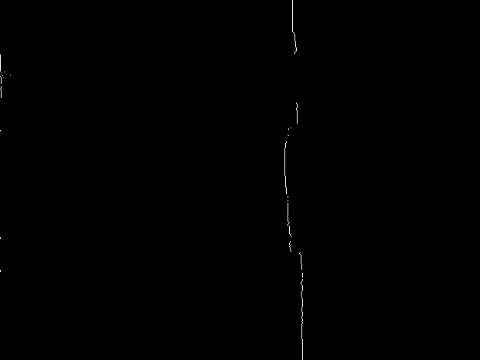

5 charuco_laser_40.png


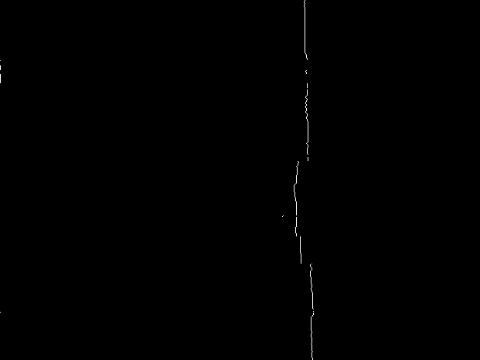

6 charuco_laser_30.png


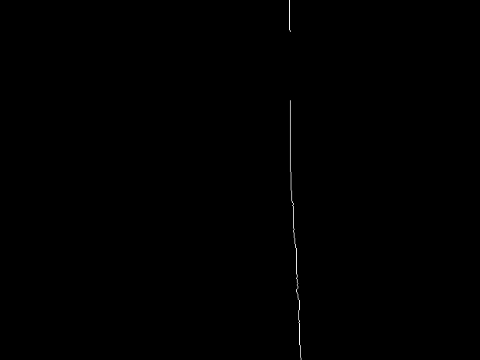

7 charuco_laser_41.png


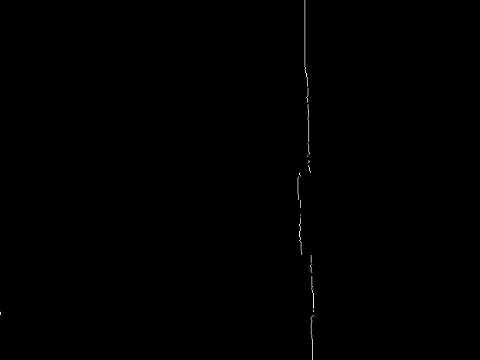

8 charuco_undist_30.png


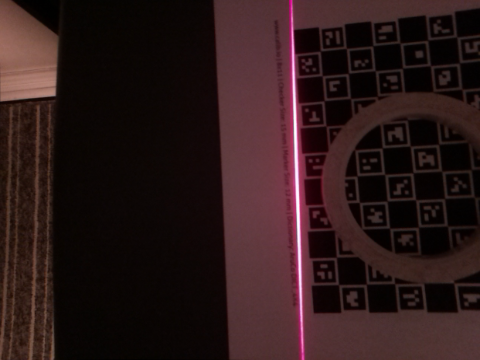

9 charuco_undist_31.png


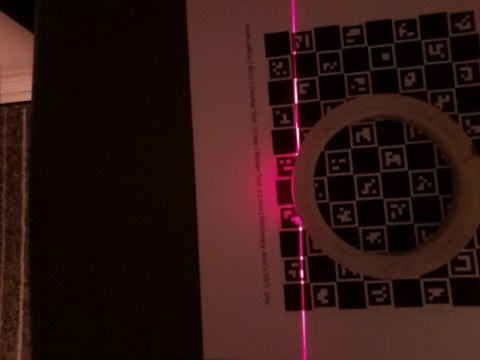

10 charuco_undist_33.png


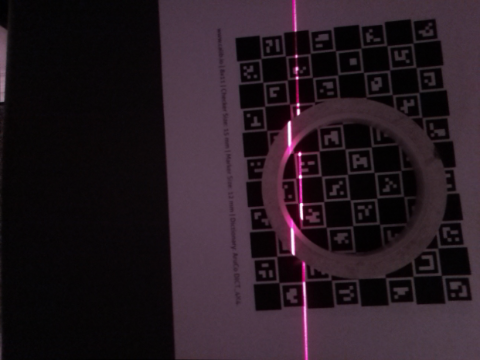

11 charuco_undist_32.png


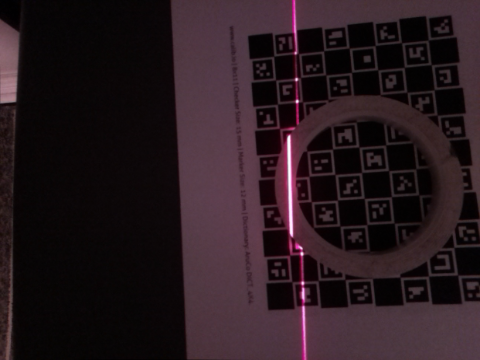

12 charuco_undist_34.png


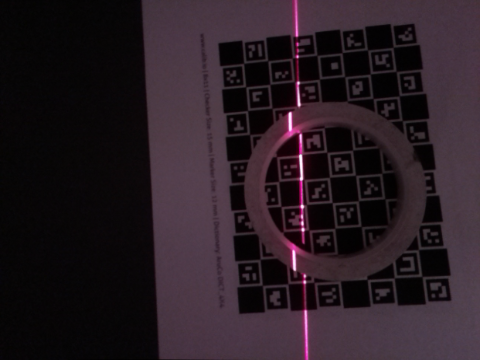

13 charuco_undist_35.png


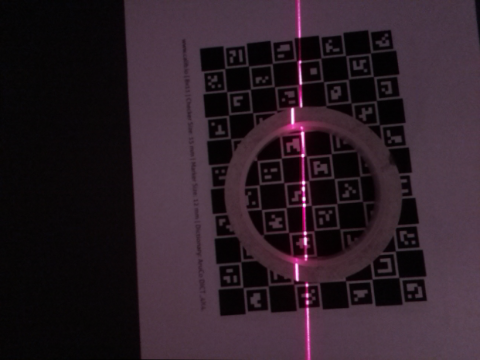

14 charuco_undist_36.png


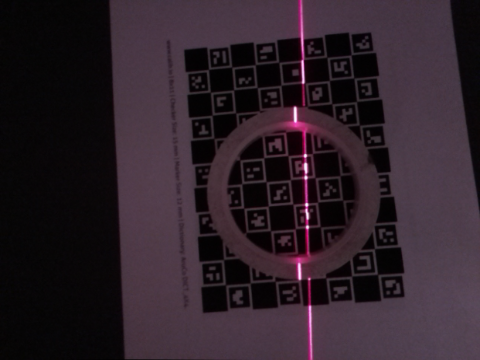

15 charuco_undist_37.png


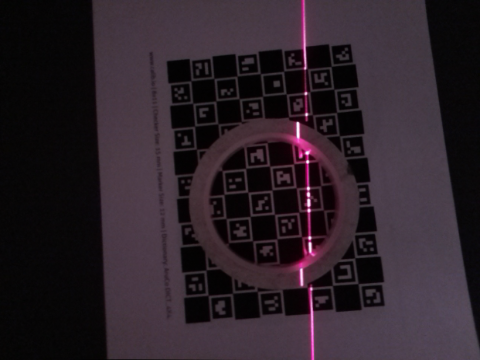

16 charuco_undist_38.png


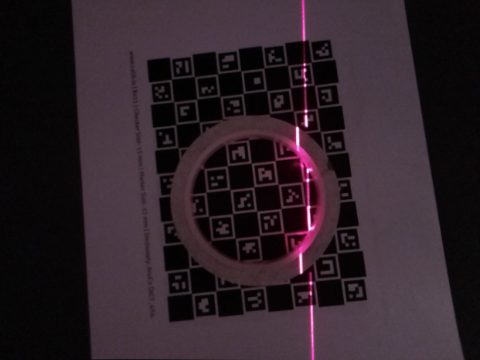

17 charuco_undist_39.png


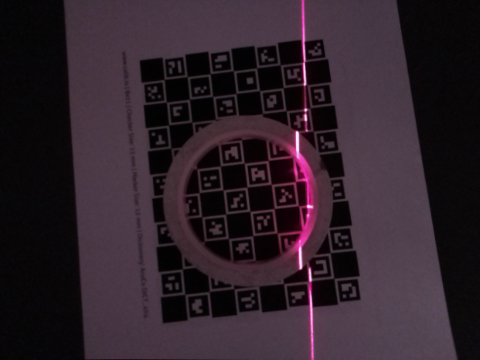

18 charuco_undist_40.png


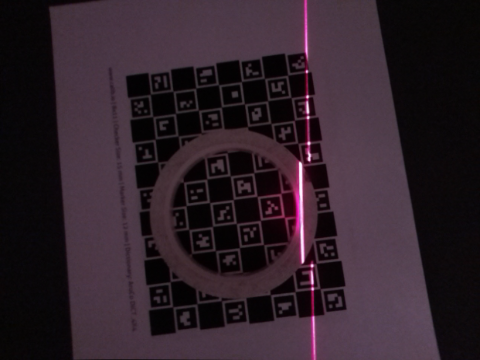

19 charuco_undist_41.png


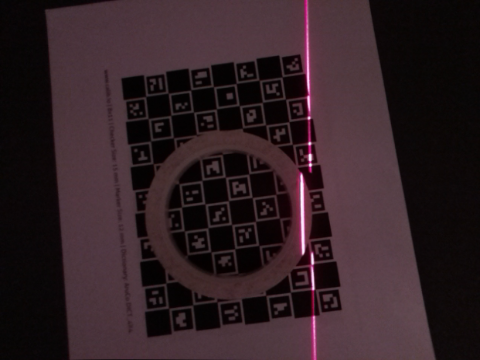

20 charuco_undist_42.png


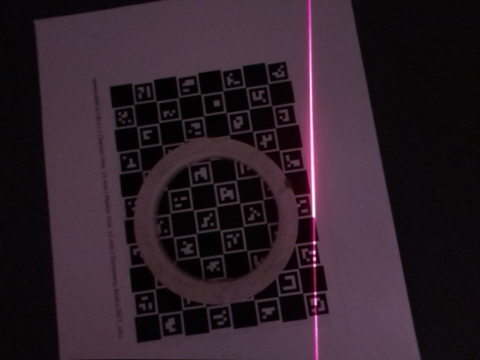

21 charuco_undist_43.png


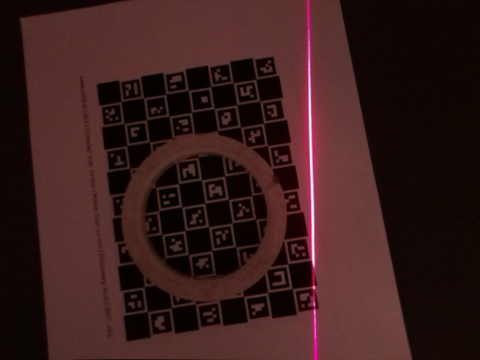

In [4]:
for idx, f in enumerate(aruco_samples):
    print(idx, f)
    disp_file(f)

In [5]:
import os 

os.getcwd()

'/home/abhi/Code/3D-Scanner/res/pose_samples/charuco/tests/sweep'

In [6]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
board = aruco.CharucoBoard_create(11, 8, 1.5, 1.2, aruco_dict)

In [7]:
import glob, os

charuco_samples = []
# os.chdir("res/pose_samples/charuco/")
for file in sorted(glob.glob("*"), key=os.path.getmtime):
    charuco_samples.append(file)

In [8]:
charuco_samples

['charuco_laser_42.png',
 'charuco_laser_43.png',
 'charuco_laser_31.png',
 'charuco_laser_33.png',
 'charuco_laser_32.png',
 'charuco_laser_40.png',
 'charuco_laser_30.png',
 'charuco_laser_41.png',
 'charuco_undist_30.png',
 'charuco_undist_31.png',
 'charuco_undist_33.png',
 'charuco_undist_32.png',
 'charuco_undist_34.png',
 'charuco_undist_35.png',
 'charuco_undist_36.png',
 'charuco_undist_37.png',
 'charuco_undist_38.png',
 'charuco_undist_39.png',
 'charuco_undist_40.png',
 'charuco_undist_41.png',
 'charuco_undist_42.png',
 'charuco_undist_43.png']

In [9]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner,
                                 winSize = (3,3),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])

        decimator+=1

    imsize = gray.shape
    return allCorners,allIds,imsize

In [10]:
allCorners,allIds,imsize=read_chessboards(charuco_samples)

POSE ESTIMATION STARTS:
=> Processing image charuco_laser_42.png
=> Processing image charuco_laser_43.png
=> Processing image charuco_laser_31.png
=> Processing image charuco_laser_33.png
=> Processing image charuco_laser_32.png
=> Processing image charuco_laser_40.png
=> Processing image charuco_laser_30.png
=> Processing image charuco_laser_41.png
=> Processing image charuco_undist_30.png
=> Processing image charuco_undist_31.png
=> Processing image charuco_undist_33.png
=> Processing image charuco_undist_32.png
=> Processing image charuco_undist_34.png
=> Processing image charuco_undist_35.png
=> Processing image charuco_undist_36.png
=> Processing image charuco_undist_37.png
=> Processing image charuco_undist_38.png
=> Processing image charuco_undist_39.png
=> Processing image charuco_undist_40.png
=> Processing image charuco_undist_41.png
=> Processing image charuco_undist_42.png
=> Processing image charuco_undist_43.png


In [11]:
def calibrate_camera(allCorners,allIds,imsize):
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")

    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    #flags = (cv2.CALIB_RATIONAL_MODEL)
    (ret, camera_matrix, distortion_coefficients0,
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [12]:
%time ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
CPU times: user 974 ms, sys: 128 µs, total: 974 ms
Wall time: 1.12 s


In [13]:
ret

0.5576046061026504

In [14]:
mtx

array([[731.92551777,   0.        , 267.43388701],
       [  0.        , 731.92551777, 218.77719628],
       [  0.        ,   0.        ,   1.        ]])

In [15]:
dist

array([[ 2.30319819e-01],
       [ 3.25653073e+00],
       [ 6.80198992e-03],
       [-1.57410011e-03],
       [-1.00717470e+01],
       [ 1.67834175e-01],
       [ 3.02948610e+00],
       [-9.28294716e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

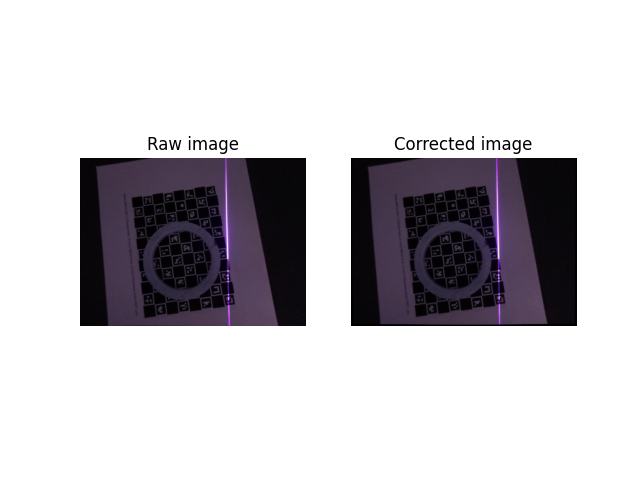

In [16]:
i=20 # select image id
plt.figure()
frame = cv2.imread(charuco_samples[i])
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

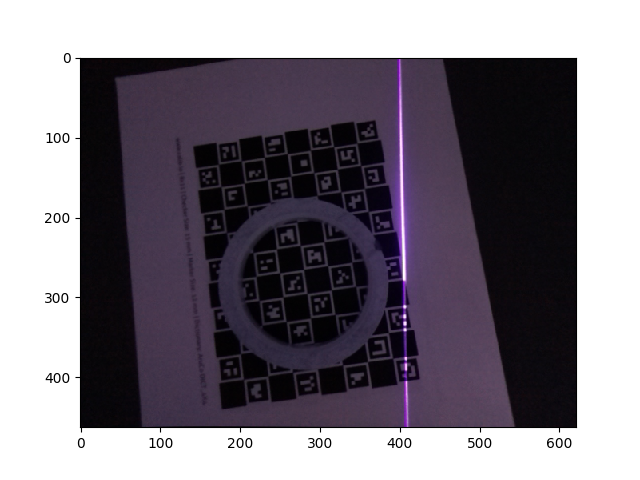

In [17]:
frame = cv2.imread(charuco_samples[20])
# frame = cv2.undistort(src = frame, cameraMatrix = mtx, distCoeffs = dist)
plt.figure()
plt.imshow(frame, interpolation = "nearest")
plt.show()


In [18]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict,
                                                      parameters=parameters)
# SUB PIXEL DETECTION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
    cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)

frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

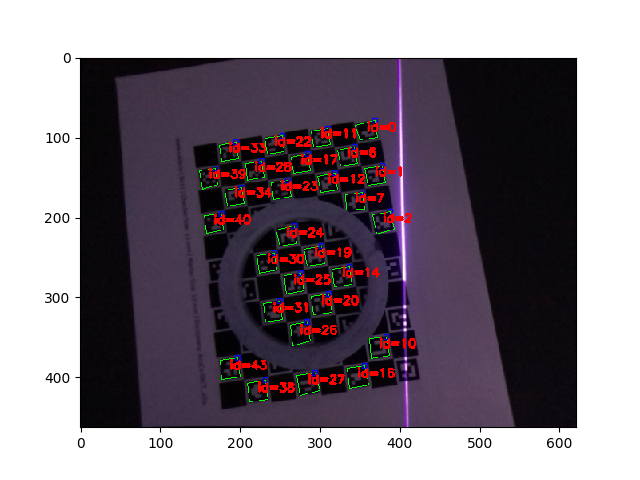

In [19]:
plt.figure()
plt.imshow(frame_markers, interpolation = "nearest")
plt.show()

In [20]:
empty_dist = np.array([0,0,0,0,0]).reshape(1,5)

In [21]:
charucoretval, charucoCorners, charucoIds = aruco.interpolateCornersCharuco(corners, ids, gray, board)

In [22]:
im_with_charuco_board = cv2.aruco.drawDetectedCornersCharuco(gray, charucoCorners, charucoIds, (0,255,0))

In [23]:
retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charucoCorners, charucoIds, board, mtx, empty_dist, rvec = False, tvec = False)  # posture estimation from a charuco board

In [24]:
im_with_charuco_board = aruco.drawAxis(im_with_charuco_board, mtx, np.array([0.0,0.0,0.0,0.0,0.0]).reshape(1,5), rvec, tvec, 100)

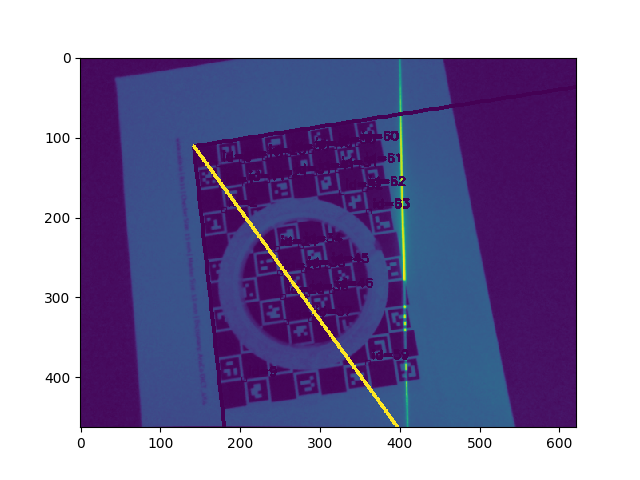

In [25]:
plt.figure()
plt.imshow(im_with_charuco_board, interpolation = "nearest")

plt.show()

## Test axis with calibrated camera params

In [26]:
# Load camera calibration data from cam_out folder
print(os.getcwd())

os.chdir("../../../../../")

with np.load('res/cal_out/cam_params.npz') as X:
    mtx, dist, rvecs, tvecs = [X[i] for i in ('mtx','dist','rvecs','tvecs')]

/home/abhi/Code/3D-Scanner/res/pose_samples/charuco/tests/sweep


In [27]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict,
                                                      parameters=parameters)
# SUB PIXEL DETECTION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
    cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)

frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

In [28]:
empty_dist = np.array([0,0,0,0,0]).reshape(1,5)

In [29]:
charucoretval, charucoCorners, charucoIds = aruco.interpolateCornersCharuco(corners, ids, gray, board)

In [30]:
im_with_charuco_board = cv2.aruco.drawDetectedCornersCharuco(gray, charucoCorners, charucoIds, (0,255,0))

In [31]:
retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charucoCorners, charucoIds, board, mtx, empty_dist, rvec = False, tvec = False)  # posture estimation from a charuco board

In [32]:
im_with_charuco_board = aruco.drawAxis(im_with_charuco_board, mtx, np.array([0.0,0.0,0.0,0.0,0.0]).reshape(1,5), rvec, tvec, 100)

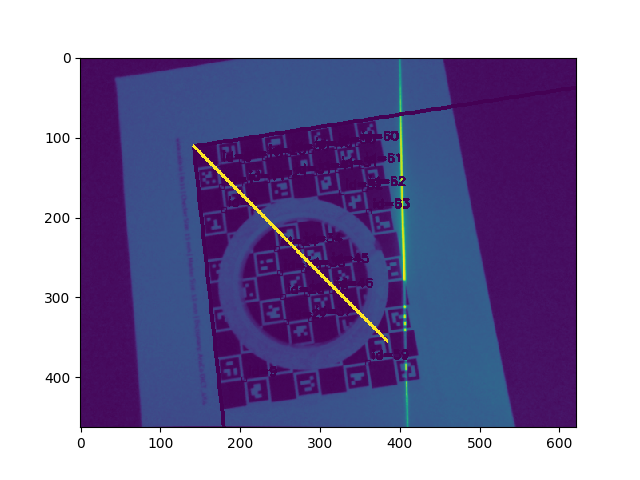

In [33]:
plt.figure()
plt.imshow(im_with_charuco_board, interpolation = "nearest")

plt.show()

## Test axis directions over multiple images

In [34]:
os.getcwd()

'/home/abhi/Code/3D-Scanner'

In [35]:
os.chdir("res/pose_samples/charuco/tests/sweep")

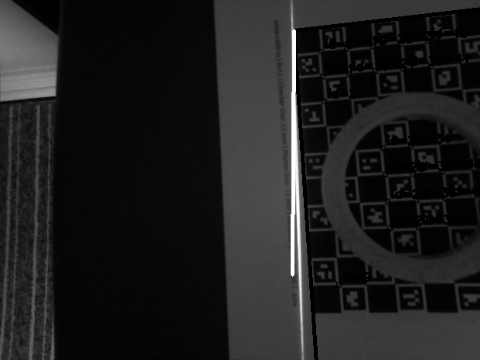

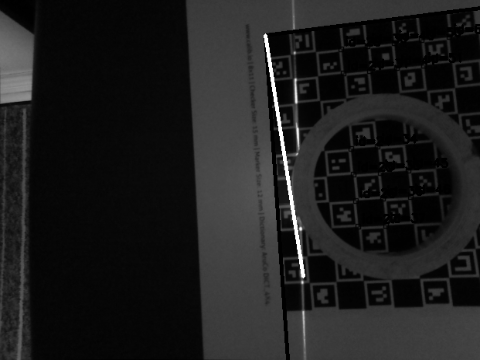

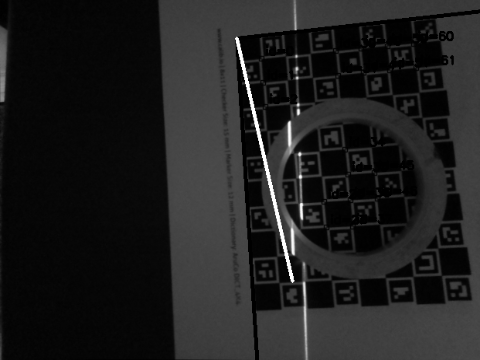

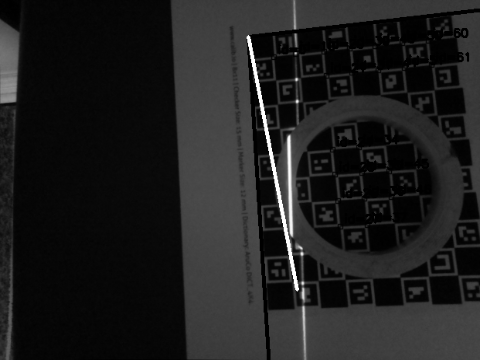

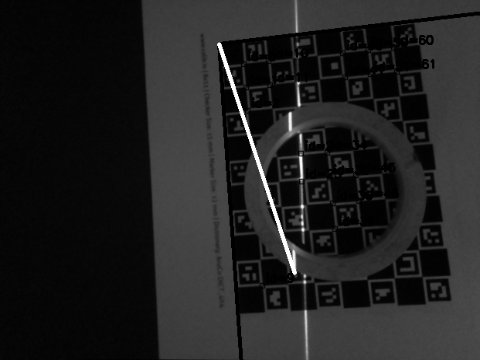

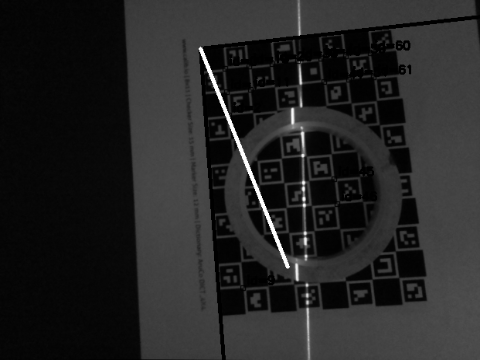

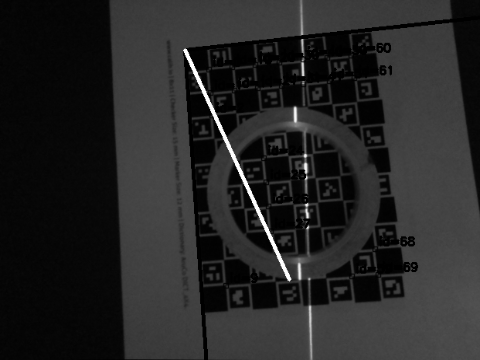

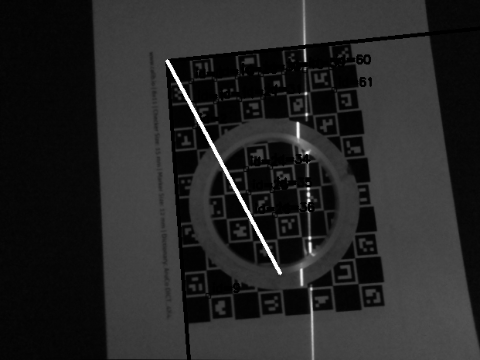

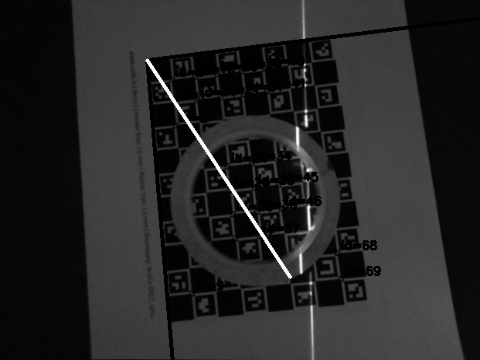

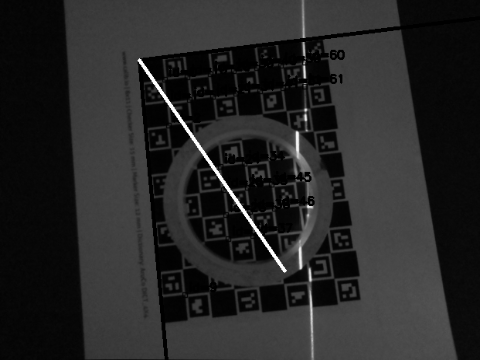

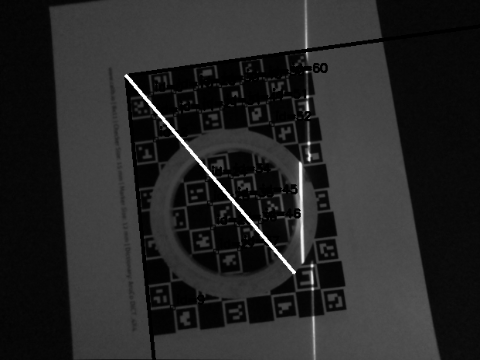

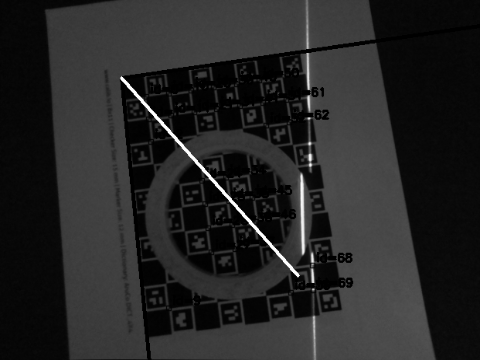

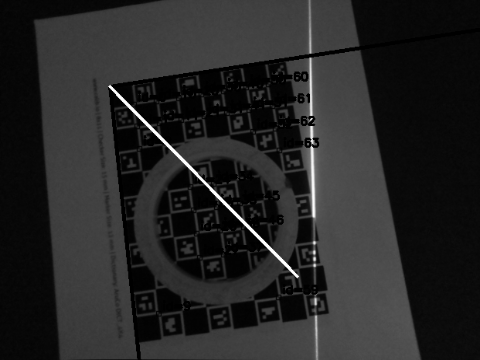

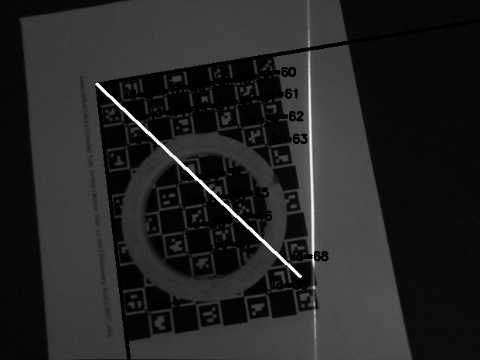

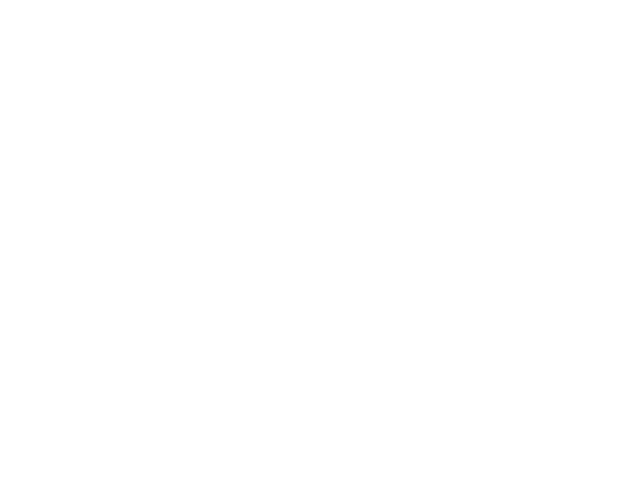

In [36]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
board = aruco.CharucoBoard_create(11, 8, 1.5, 1.2, aruco_dict)
parameters =  aruco.DetectorParameters_create()
plt.figure()

def print_axes(undist, aruco_dict, parameters, board, mtx):
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict,
                                                          parameters=parameters)
    # SUB PIXEL DETECTION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
    for corner in corners:
        cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)

    # frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
    empty_dist = np.array([0,0,0,0,0]).reshape(1,5)
    
    charucoretval, charucoCorners, charucoIds = aruco.interpolateCornersCharuco(corners, ids, gray, board)
    im_with_charuco_board = cv2.aruco.drawDetectedCornersCharuco(gray, charucoCorners, charucoIds, (0,255,0))
    retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charucoCorners, charucoIds, board, mtx, empty_dist, rvec = False, tvec = False)  # posture estimation from a charuco board
    im_with_charuco_board = aruco.drawAxis(im_with_charuco_board, mtx, np.array([0.0,0.0,0.0,0.0,0.0]).reshape(1,5), rvec, tvec, 100)
    
    disp_img(im_with_charuco_board)
    # plt.imshow(im_with_charuco_board, interpolation = "nearest")
    # plt.show()

for img in charuco_samples:
    if "undist" in img:
        undist = cv2.imread(img)
        print_axes(undist, aruco_dict, parameters, board, mtx)
        


## Transform triangulated points with each coordinate transform

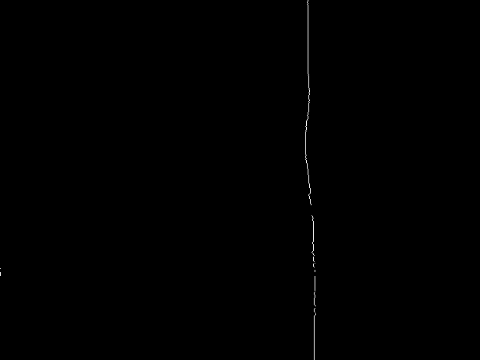

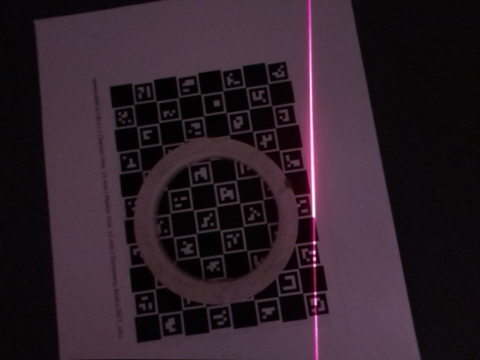

In [37]:
disp_file(charuco_samples[0])
disp_file(charuco_samples[20])

In [38]:
# Function to get inverse of 3x1 rotation vector as a 3x3 matrix
def get_itf(rvec, tvec):
    dst, jac = cv2.Rodrigues(rvec)
    extrinsics = np.eye(4)
    extrinsics[:3, :3] = dst
    extrinsics[:3, 3] = tvec.flatten()
    return np.linalg.inv(extrinsics)

In [39]:
def get_tf(undist, aruco_dict, parameters, board, mtx):
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict,
                                                          parameters=parameters)
    if ids is not None:
        # SUB PIXEL DETECTION
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
        for corner in corners:
            cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)

        empty_dist = np.array([0,0,0,0,0]).reshape(1,5)

        charucoretval, charucoCorners, charucoIds = aruco.interpolateCornersCharuco(corners, ids, gray, board)
        im_with_charuco_board = cv2.aruco.drawDetectedCornersCharuco(gray, charucoCorners, charucoIds, (0,255,0))
        retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charucoCorners, charucoIds, board, mtx, empty_dist, rvec = False, tvec = False) 
        return retval, rvec, tvec
    else:
        return False, 0, 0

In [40]:
def extract_laser(frame): 
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # define range of blue color in HSV
    lower_colour = np.array([146, 62, 0])
    upper_colour = np.array([255, 255, 255])
    
    # Threshold the HSV image to get only get red colour
    mask = cv2.inRange(hsv, lower_colour, upper_colour)
    
    # Isolate the red channel
    img = frame[...,2]
    ret,img = cv2.threshold(img,144,255,0)

    # Create emptry array of zeros of same size as img
    out = np.zeros_like(img)

    # For each row, get the position of the highest intensity
    bppr = np.argmax(img, axis=1)

    # Set the highest intensity pixel locations to 255
    out[np.arange(bppr.shape[0]), bppr] = 255
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(out,out, mask= mask)
    
    return res, bppr


In [41]:
def get_laser_pts(img, POI):
    
    # Obtain the width and height of the camera
    h, w = img.shape

    # Get new camera matrix
    new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # dist b/w camera and laser is 4 in
    X = 101.6
    cam_angle = 30
    
    fx = new_mtx[0][0]
    fy = new_mtx[1][1]
    f = int(0.5*(fx+fy))
        
    # Scale factor for y direction
    Y_SCALE = 0.321

    # Camera params
    centre_x = int(w/2)
    centre_y = int(h/2)

    b0 = X;
    C0 = cam_angle;

    POI_len = POI.shape[0]
    
    # L_PTS (pixel coordinates)
    l_pts = np.zeros((POI_len,3))
    l_pts[:,0] = POI - centre_x
    l_pts[:,1] = centre_y - np.arange(POI_len)
    l_pts[:,2] = 100
    
    x = l_pts[:, 0]
    y = l_pts[:, 1]
    z = l_pts[:, 2]

    cam_pts = np.zeros((POI_len,3))
    
    delta_px_x0 = l_pts[:,0]
    A0 = 90 + np.degrees(np.arctan(delta_px_x0/f))
    B0 = 180 - (A0 + C0)
    a0 = (np.sin(np.deg2rad(A0))*b0)/np.sin(np.deg2rad(B0))    
    h1 = a0 * np.cos(np.arctan(delta_px_x0/f))
    
    cam_pts[:,2] = h1
    cam_pts[:,1] = l_pts[:,1] * Y_SCALE
    cam_pts[:,0] = 0
    
    return cam_pts


In [42]:
def transformed_points(undist):
    # Grab the undistorted images and laser sample pair
    undist = cv2.imread(undist)
    
    # Perform pose detection on the undistorted images and obtain rvec, and tvec of the board
    retval, rvec, tvec = get_tf(undist, aruco_dict, parameters, board, mtx)
        
    if retval:
        
        # Get the 4x4 coordinate transform from the rvecs and tvecs
        tf = get_itf(rvec, tvec)

        # Perform triangulation on the laser samples and obtain mx3 matrix of points 
        laser, POI  = extract_laser(undist)
        cam_pts = get_laser_pts(laser, POI)
        
        # Add a column of ones to the mx3 matrix such that it is mx4
        cam_pts = np.hstack((cam_pts, np.ones((len(POI), 1))))
        
        # Transpose the matrix so that it is 4xm (i.e. each column is one point)
        cam_pts = cam_pts.transpose()
        
        print("Successfully performed operation!")
        
        # Multiply coordinate transofrm (4x4) for each point (4x1) to get a point that is transformed 
        return tf@cam_pts
    
    # Reject and log undected charuco board
    else:
        print("Could not perform pose detection on current frame!")
        return None

In [43]:
full_pt_cloud = []
for sample in charuco_samples:
    tf_pts = transformed_points(sample)
    if tf_pts is not None:
        full_pt_cloud.append(tf_pts)

Could not perform pose detection on current frame!
Could not perform pose detection on current frame!
Could not perform pose detection on current frame!
Could not perform pose detection on current frame!
Could not perform pose detection on current frame!
Could not perform pose detection on current frame!
Could not perform pose detection on current frame!
Could not perform pose detection on current frame!
Successfully performed operation!
Successfully performed operation!
Successfully performed operation!
Successfully performed operation!
Successfully performed operation!
Successfully performed operation!
Successfully performed operation!
Successfully performed operation!
Successfully performed operation!
Successfully performed operation!
Successfully performed operation!
Successfully performed operation!
Successfully performed operation!
Successfully performed operation!


In [44]:
# Combine into one large numpy array

#TODO: Keep image dimensions (post undistortion) as global variable and replace with 463 below
final_cloud = np.empty((3, len(full_pt_cloud)*463)) 

for idx, np_arr in enumerate(full_pt_cloud):
    final_cloud[0:3, idx*463:idx*463+463] = np_arr[0:3,:]
    

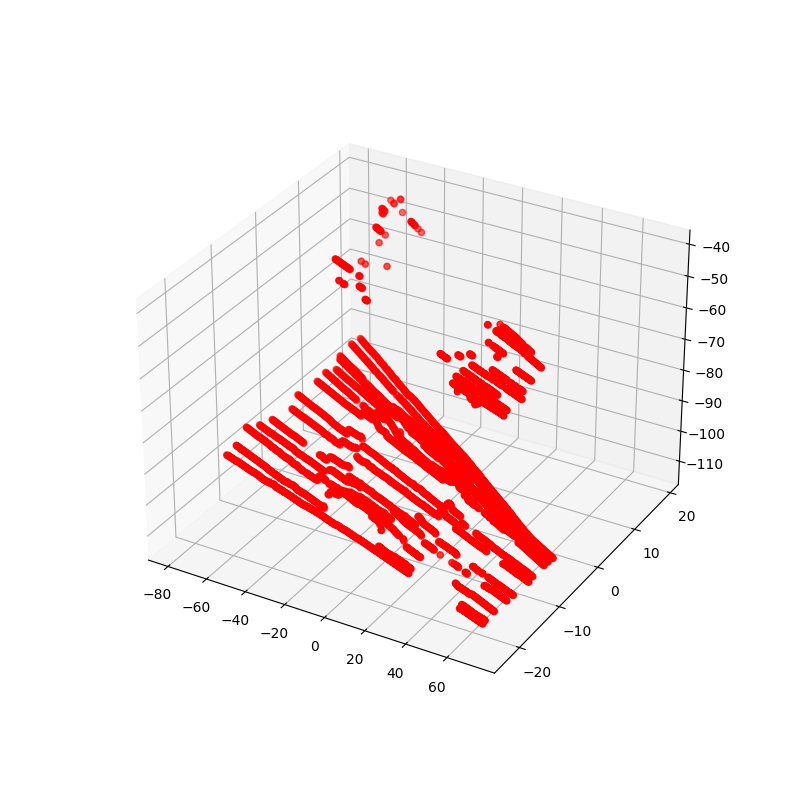

In [45]:
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# for out in full_pt_cloud:
    # print(out)
ax.scatter(final_cloud[0,:], final_cloud[1,:], final_cloud[2,:], color='#ff0000')

plt.show()

In [46]:
# Size of array in mb
final_cloud.nbytes / 1000000

0.155568

In [47]:
os.chdir('../../../../../')
os.getcwd()

'/home/abhi/Code/3D-Scanner'

In [48]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()

pcd.points = o3d.utility.Vector3dVector(final_cloud.T)
o3d.io.write_point_cloud("res/point_clouds/final_cloud.ply", pcd)

True